In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from numpy import asarray, zeros

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# helper functions

In [2]:
def clean_text(text):
    text = text.lower()
    ## remove \n \t and non-alphanumeric
    text = re.sub("(\\t|\\n)", " ", text)
    text = re.sub("[^a-zA-Z0-9']", " ", text)
    text = text.strip()
    ## leave 1 space between each token
    text = " ".join([x for x in text.split(" ") if len(x.strip()) > 0])
    return text.strip()

# print(clean_text('""""sherman...K...k,...don\'t"'))

toxic_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]


In [3]:
train = pd.read_csv("train_evenly_distributed.csv")
evaluation = pd.read_csv("test.csv")
evaluation_labels = pd.read_csv("test_labels.csv")

In [4]:
## sum of each category
print(train[toxic_labels].sum())


toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [5]:
## non-toxic
count = 0

def is_toxic(row):
    for label in toxic_labels:
        if row[label] == 1:
            return True
    return False

for i, row in train.iterrows():
    if not is_toxic(row):
        count += 1

print(count)

6000


In [6]:
## create train test split
X = train["comment_text"].tolist()
y = train[toxic_labels].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# basic naive bayes theorem

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

nb = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", MultinomialNB()),
    ]
)

## need to make [0, 0, 0, 1, 0, 1] --> 000101 for the model to understand
y_train_NB = []
for row in y_train:
    y_train_NB.append("".join([str(_) for _ in row]))

## same for test
y_test_NB = []
for row in y_test:
    y_test_NB.append("".join([str(_) for _ in row]))

nb.fit(X_train, y_train_NB)

y_pred_NB = nb.predict(X_test)

print("accuracy %s" % accuracy_score(y_pred_NB, y_test_NB))


accuracy 0.48391451068616426


In [8]:
## create tokeniser
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

## Convert sentences to vectors
X_train_vectors = tokenizer.texts_to_sequences(X_train)
X_test_vectors = tokenizer.texts_to_sequences(X_test)

max_length = 0
for row in X_train_vectors + X_test_vectors:
    max_length = max(max_length, len(row))

## added extra 10 to max_length just in case future vecotrs are longer
max_length += 10

## add extra 0 to make sure all vectors are same length
X_train_vectors = pad_sequences(X_train_vectors, padding="post", maxlen=max_length)
X_test_vectors = pad_sequences(X_test_vectors, padding="post", maxlen=max_length)

vocab_length = len(tokenizer.word_index) + 1

print(f"The length of vocab is {vocab_length}")

print(len(X_train_vectors))
print(len(X_test_vectors))

The length of vocab is 43886
17780
4445


In [9]:
## using the GloVe file to convert words to int representation for faster training
## alternative is word2vec but word2vec uses local statistics but GloVe uses global statistics
## https://nlp.stanford.edu/data/glove.6B.zip

embeddings_dictionary = dict()

with open('glove/glove.6B.100d.txt', encoding="utf8") as glove_file:
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

## 100 is cuz we using the 100d version of glove
embedding_matrix = zeros((vocab_length, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# First model
## Layers
1. Input layer
2. Embedding layer
3. LSTM layer with 128 neurons 
4. Output layer with 6 neurons (for the 6 labels)

In [10]:
from keras.layers import Input
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, LSTM
from keras.layers.core import Activation, Dropout, Dense

In [11]:
inputs = Input(shape=(max_length,))
embedding_layer = Embedding(
    vocab_length, 100, weights=[embedding_matrix], trainable=False
)(inputs)
batch_size = 128
lstm_layer = LSTM(batch_size)(embedding_layer)
dense_layer = Dense(6, activation="sigmoid")(lstm_layer)
model = Model(inputs=inputs, outputs=dense_layer)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])


In [12]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1410)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1410, 100)         4388600   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 4,506,622
Trainable params: 118,022
Non-trainable params: 4,388,600
_________________________________________________________________
None


In [13]:
magic = model.fit(
    X_train_vectors, y_train, batch_size=128, epochs=2, verbose=1, validation_split=0.2
)
model.save('lstm_model.h5')

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpag5qzusa.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpag5qzusa.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
  1/112 [..............................] - ETA: 30:54 - loss: 0.6931 - acc: 0.9844

In [ ]:
magic = model.fit(
    X_train_vectors, y_train, batch_size=128, epochs=2, verbose=1, validation_split=0.2
)
model.save('lstm_model.h5')

Epoch 1/5
798/798 [==============================] - 1161s 1s/step - loss: 0.1848 - acc: 0.8958 - val_loss: 0.1426 - val_acc: 0.9943
Epoch 2/5
798/798 [==============================] - 1462s 2s/step - loss: 0.1409 - acc: 0.9945 - val_loss: 0.1431 - val_acc: 0.9943
Epoch 3/5
798/798 [==============================] - 1439s 2s/step - loss: 0.1410 - acc: 0.9943 - val_loss: 0.1427 - val_acc: 0.9943
Epoch 4/5
798/798 [==============================] - 1247s 2s/step - loss: 0.1406 - acc: 0.9939 - val_loss: 0.1424 - val_acc: 0.9943
Epoch 5/5
798/798 [==============================] - 1086s 1s/step - loss: 0.1438 - acc: 0.9943 - val_loss: 0.1432 - val_acc: 0.9943


In [ ]:
score = model.evaluate(X_test_vectors, y_test, verbose=1)

print(f"Test Score: {score[0]}")
print(f"Test Accuracy: {score[1]}")

998/998 [==============================] - 206s 206ms/step - loss: 0.1425 - acc: 0.9941
Test Score: 0.1425277590751648
Test Accuracy: 0.9941093325614929


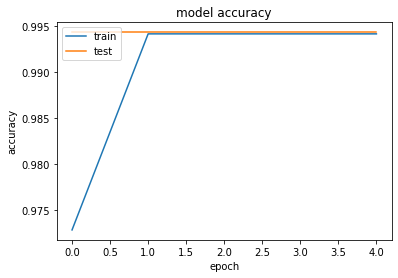

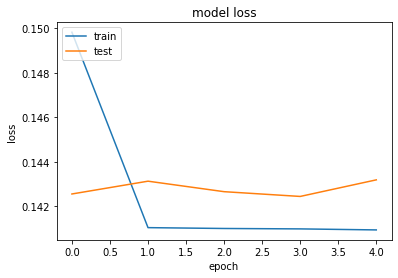

In [ ]:
## check for overfitting
plt.plot(magic.history['acc'])
plt.plot(magic.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(magic.history['loss'])
plt.plot(magic.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
from keras.models import load_model

model = load_model('lstm_model.h5')


In [ ]:
showcase = ["Who gave you permission to speak you fucker!!! Go kill yourself", "What a lovely presentation, well done!"]

showcase_tokens = tokenizer.texts_to_sequences(showcase)
showcase_vectors = pad_sequences(showcase_tokens, padding="post", maxlen=max_length)

y_hat = model.predict(showcase_vectors, verbose=0)

y_hat_rounded = []
for row in y_hat:
    y_hat_rounded.append([x for x in row])
y_hat_rounded

[[0.08897737,
  0.012645245,
  0.049181044,
  0.0016247332,
  0.041928947,
  0.006444037],
 [0.08897737,
  0.012645185,
  0.049181014,
  0.0016247332,
  0.041928947,
  0.006444037]]